# Support Vector Machine

In [1]:
import kagglehub
import pandas as pd
import numpy as np

path = kagglehub.dataset_download("mansoordaku/ckdisease", path="kidney_disease.csv")
print("Dataset Path: ", path)

df = pd.read_csv(path)

Dataset Path:  /home/marius/.cache/kagglehub/datasets/mansoordaku/ckdisease/versions/1/kidney_disease.csv


## Preprocessing
As we could observe there is preprocessing need to be done before actual work.
- drop "id" colum
- apply label encoding
- remove unwanted characters
- solve problems with missing values (NaN)
- replace "ckd	" with "ckd"

In [2]:
# first let's drop the "id" column
df = df.drop("id", axis=1)

# replacing that extra "ckd	" with "ckd"
df = df.replace("ckd\t", "ckd")

# applying label encoding
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

list_of_columns = ["classification", "rbc", "pc", "pcc", "ba", "bgr", "htn", "dm", "cad", "appet", "pe", "ane"]
for column_name in list_of_columns:
    df[column_name] = le.fit_transform(df[column_name])

# removing unexpected characters 
df = df.replace('\t?', np.nan)
df = df.replace('	?', np.nan)

# covert to numeric
list_to_convert = ["pcv","wc", "rc"]

for column_name in list_to_convert:
    df[column_name] = pd.to_numeric(df[column_name])


# for repair the missing values I will use reparo from Sigmoid
from reparo import CDI

imputer = CDI()
imputer.apply(df, df.columns)

## Performance of the algorithm influenced by feature scale

> 2. Firstly we will explore how the performance of the algorith is influenced by the feature scale. Train a SVM  >   model on 4 versions of the data set:
 >      1. Initial one.
 >      2. The one passed trought the StandardScaler.
 >      3. The one passed trought the MinMaxScaler.
 >      4. The one passed trought the MaxAbsScaler.

In [3]:
from sklearn.metrics import accuracy_score
from sklearn import svm
from sklearn.preprocessing import MaxAbsScaler, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

scalers = {
    "initial" : None,
    "standard_scale": StandardScaler(),
    "min_max_scaler": MinMaxScaler(),
    "max_abs_scaler":  MaxAbsScaler(),
}

train_columns = df.drop("classification", axis=1).to_numpy()
target_column = df["classification"].to_numpy()

x, x_test, y, y_test = train_test_split(train_columns, target_column, test_size=0.3, random_state=42)

results = pd.DataFrame({})
for name, scaler  in scalers.items():
    
    if scaler is not None:
        scaler.fit(x, y)
        x = scaler.transform(x)
    
    clf = svm.LinearSVC(dual='auto')
    clf.fit(x, y)
    
    prediction = clf.predict(x_test)
    accuracy = accuracy_score(y_test, prediction)
    
    results[name] = [accuracy]
results


,initial,standard_scale,min_max_scaler,max_abs_scaler
0,0.991667,0.633333,0.633333,0.633333


So as we could observe the applied scale diminished the accuracy score. The reason behind it lays in the data and the way SVM works. For further explanation a data analysis is required. Overall we could conclude that LinearSVC is sensitive to scaling.

### SVMs using different kernels
Usually SVMs use some Kernel to move the data to another space where linear planes that separates the classes. In this task you will have to explore how different kernels are influencing the decision boundary. Create the plots of decision boundary for the following kernels:
1. linear
2. poly
3. rbf
4. sigmoid

<Axes: >

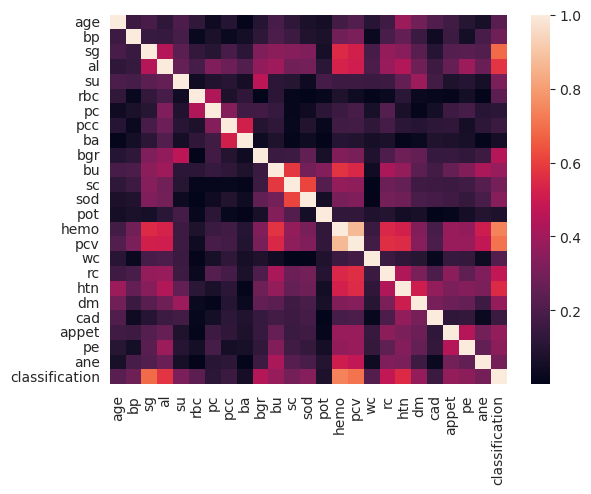

In [4]:
import seaborn as  sns

sns.heatmap(abs(df.corr()))

In [5]:
abs(df.corr()["classification"]).sort_values()[::-1]

classification    1.000000
hemo              0.740400
pcv               0.703263
sg                0.687916
al                0.575956
htn               0.549034
rc                0.476294
bgr               0.443865
bu                0.378556
dm                0.371555
appet             0.368498
pe                0.349645
sod               0.338813
su                0.310582
sc                0.299613
ane               0.297587
bp                0.280883
rbc               0.239595
age               0.227204
wc                0.218757
pcc               0.154336
cad               0.153681
pc                0.114280
pot               0.074490
ba                0.056138
Name: classification, dtype: float64

### Decision Boundary
pcv and hemo will be our features for creating the decision boundary.

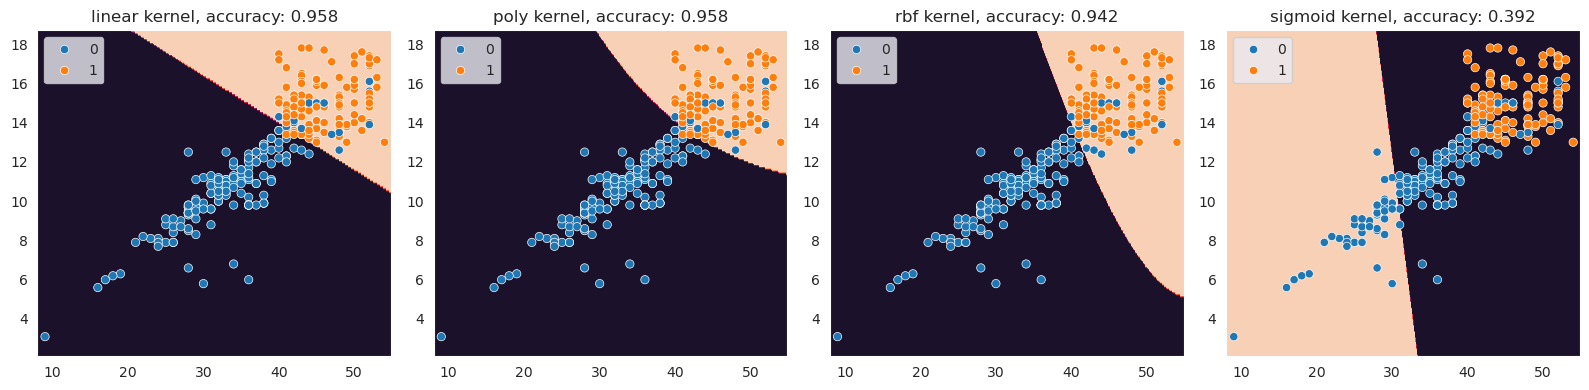

In [6]:
import numpy as np
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns

features = ['pcv', 'hemo']
kernels = ['linear', 'poly',  'rbf', 'sigmoid']

train_columns = df.drop("classification", axis=1)
target_column = df["classification"].to_numpy()
selected_columns = train_columns[features].to_numpy()

x, x_test, y, y_test = train_test_split(selected_columns, target_column, test_size=0.3, random_state=42)

minX, maxX = x[:, 0].min() - 1, x[:, 0].max() + 1
minY, maxY = x[:, 1].min() - 1, x[:, 1].max() + 1

x_values = np.arange(minX, maxX, 0.1)
y_values = np.arange(minY, maxY, 0.1)
xx, yy = np.meshgrid(x_values, y_values)

r1, r2 = xx.flatten(), yy.flatten()
r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
grid = np.hstack((r1, r2))

fig, ax = plt.subplots(1, 4, figsize=(16, 4))
for i, kernel in enumerate(kernels):
    model = SVC(kernel=kernel, random_state=42)
    model.fit(x, y)

    y_pred = model.predict(grid)
    zz = y_pred.reshape(xx.shape)
    score = model.score(x_test, y_test)

    ax[i].contourf(xx, yy, zz)
    ax[i].set_title(f'{kernel} kernel, accuracy: {score:.3f}')
    sns.scatterplot(x=x[:, 0], y=x[: ,1], hue=y, ax=ax[i])

plt.tight_layout()
plt.show()

As we could observe the least accurate is the sigmoid function which is obviously not suited for this type of tasks. Also, a good observation even though the linear and poly have the same accuracy the poly kernel seem more accurate by looking a decision boundary.